# Project 
 
Authors: Joseph Weibel, Rebecka Fahrni

Data: Sleep-EDF of PhysioNet

## Project Part 1: Recap 



***Project Data & Task Description***

The sleep-edf database contains 197 whole-night PolySomnoGraphic sleep recordings, containing EEG, EOG, chin EMG, and event markers. Some records also contain respiration and body temperature. Corresponding hypnograms (sleep patterns) were manually scored by well-trained technicians according to the Rechtschaffen and Kales manual. The recordings are stored in European Data Format (EDF). The goal of this project is to develop a model that can classify age (over 80 vs. under 25) or sleep stages/based on the polysomnographic recordings. The model will be trained on a subset of the Sleep-EDF database and evaluated on another subset. The performance of the model will be assessed using metrics such as accuracy, precision, recall, and F1 score.


standart positions of the electrodes:
- Fpz-Cz (EEG)
- Pz-Oz (EEG)

see: 


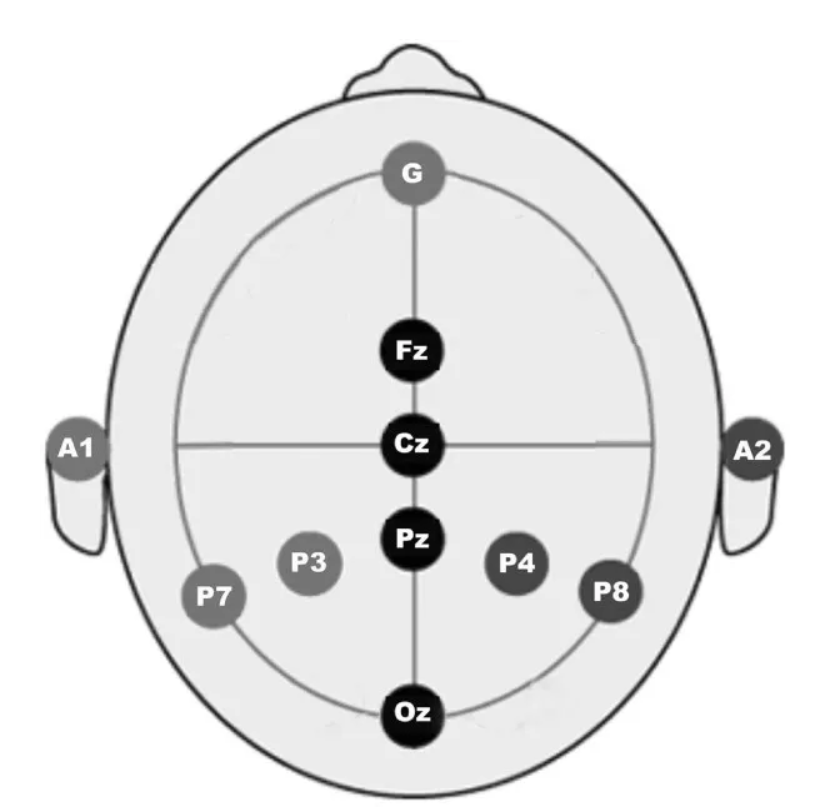

In [6]:
import mne
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import welch, spectrogram
from mne.datasets.sleep_physionet.age import fetch_data
valid_subjects = [i for i in range(83) if i not in [36, 39, 68, 52, 69, 78, 79, 13]]
# 75 subjects
recordings = [1] # only one recording per subject
mne.set_log_level('ERROR')
fnames = fetch_data(subjects=valid_subjects, recording=recordings, on_missing='warn')



In [7]:
import numpy as np
import os
import mne


def loading_raw(raw_fname, annot_fname, load_eeg_only=True,
                             crop_wake_mins=30 ):
    """ Load a raw file and its annotations, crop it around sleep events"""

    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, infer_types=True, preload=True, stim_channel="Event marker", verbose="error")
    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=False)

    if not load_eeg_only:
        raw.set_channel_types(mapping)

    if crop_wake_mins > 0:  # crop around sleep events
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] for x in annots.description]
        sleep_event_inds = np.where(mask)[0]
        tmin = max(0, annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60)  # Ensure tmin is not negative
        tmax = min(raw.times[-1], annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60)  # Adjust tmax to not exceed the raw data length
        raw.crop(tmin=tmin, tmax=tmax)

    # rename eeg
    ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

    return raw

def fetch_demographics(fnames):
    """ Get and parse demographic information such as age and gender. """
    participant_ages = []
    participant_gender = []

    for file_info in fnames:
        raw = mne.io.read_raw_edf(file_info[0], preload=True)
        subject_info = raw.info.get('subject_info', {})

        if 'last_name' in subject_info:  # Age is mislabeled as last_name
            age_str = subject_info['last_name']
            age = int(age_str.rstrip('yr'))
            participant_ages.append(age)

        if 'sex' in subject_info:
            gender = 'male' if subject_info['sex'] == 1 else 'female'
            participant_gender.append(gender)

    print(len(participant_ages))

    print(len(participant_gender))
    return participant_ages, participant_gender



In [8]:
def plot_age_distribution(ages):
    """ age distribution of participants. """
    plt.figure(figsize=(10, 6))
    plt.hist(ages, bins=10, edgecolor='black', alpha=0.7)
    plt.xlabel("Age")
    plt.ylabel("Number of Subjects")
    plt.title("Age Distribution")
    plt.show()


ages, genders = fetch_demographics(fnames)
#plot_age_distribution(ages)





75
75


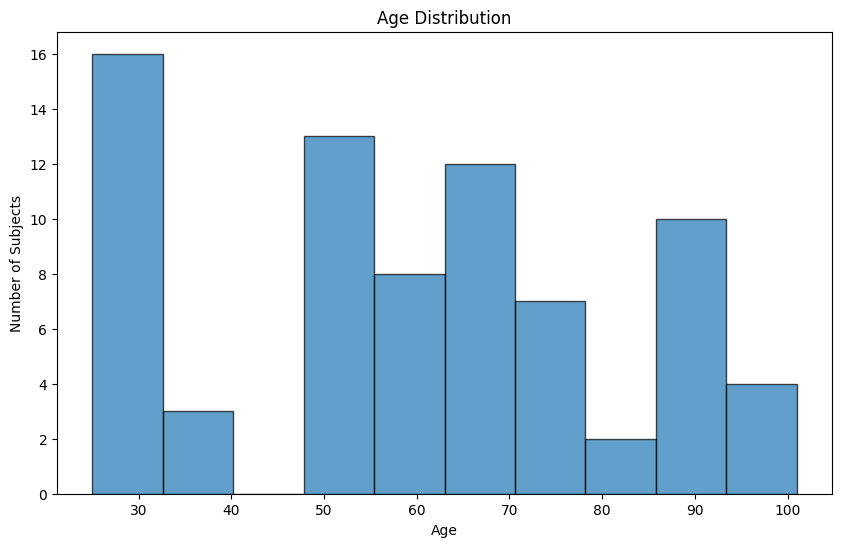

In [9]:
plot_age_distribution(ages)

In [10]:
# subset later subjects over 80 and under 30
def create_subset(fnames, ages, min_age=30, max_age=80):
    """ Create a subset of subjects based on age. """
    valid_subjects = [i for i, age in enumerate(ages) if min_age <= age <= max_age]
    print(f"Number of valid subjects: {len(valid_subjects)}")
    return [fnames[i] for i in valid_subjects]

In [11]:
raws = [loading_raw(f[0], f[1]) for f in fnames] # load all files

#### preprocessing raw data
simple filtering followed by a resampling to 100 Hz. The data is then segmented into 30s epochs with 50% overlap. The data is then split into training and test sets.

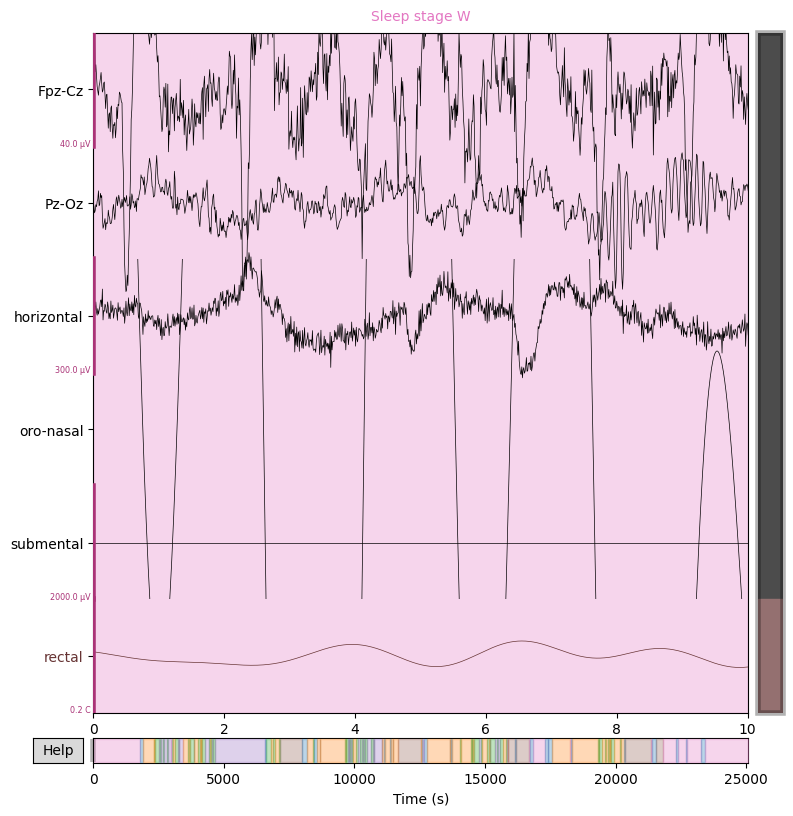

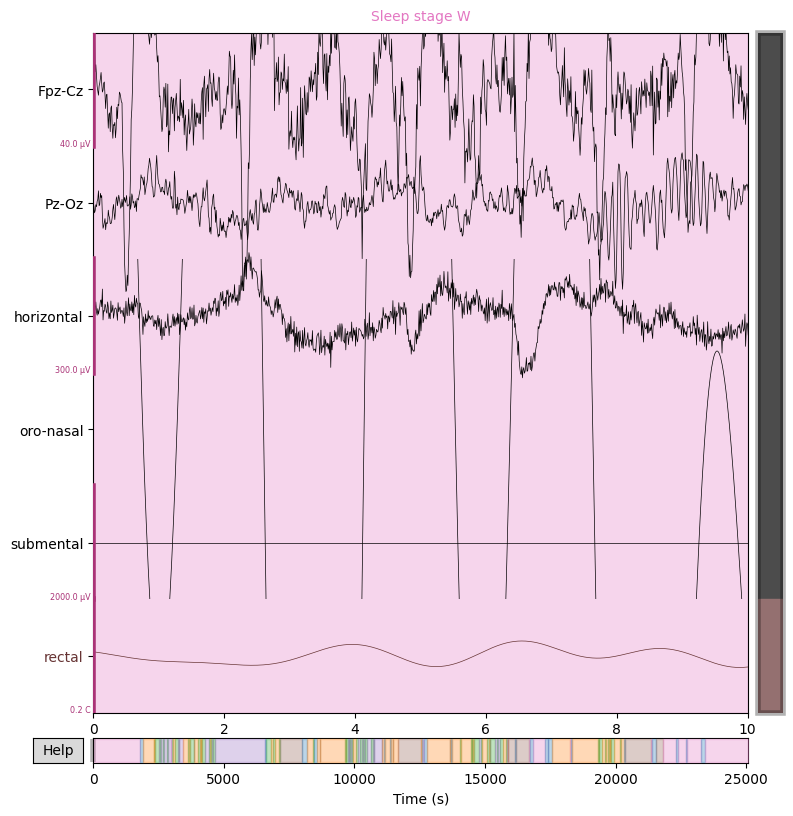

In [12]:
raws[0].plot() # before preprocessing

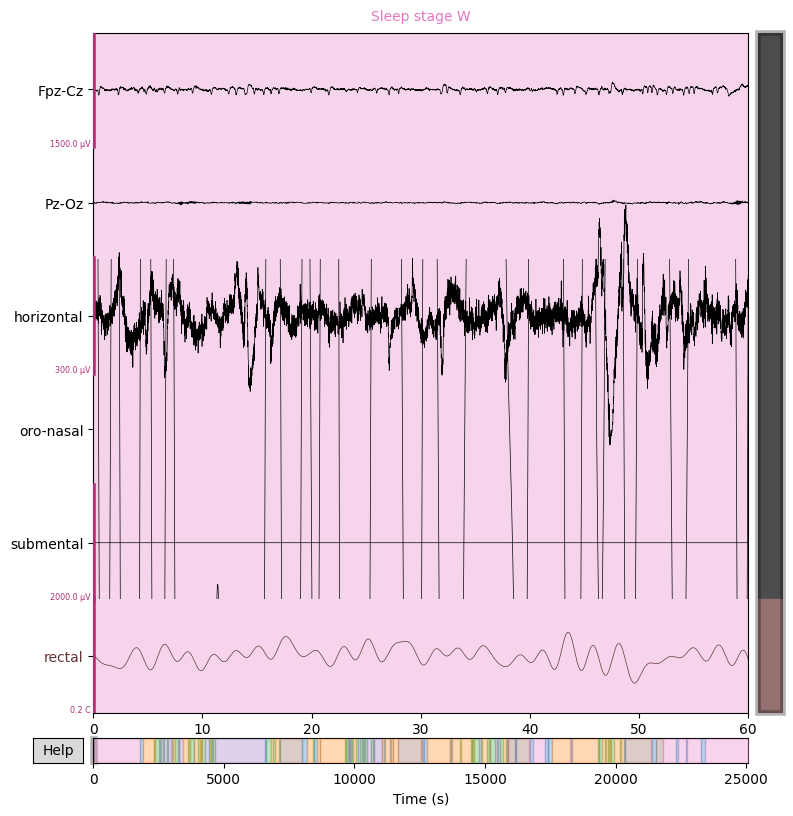

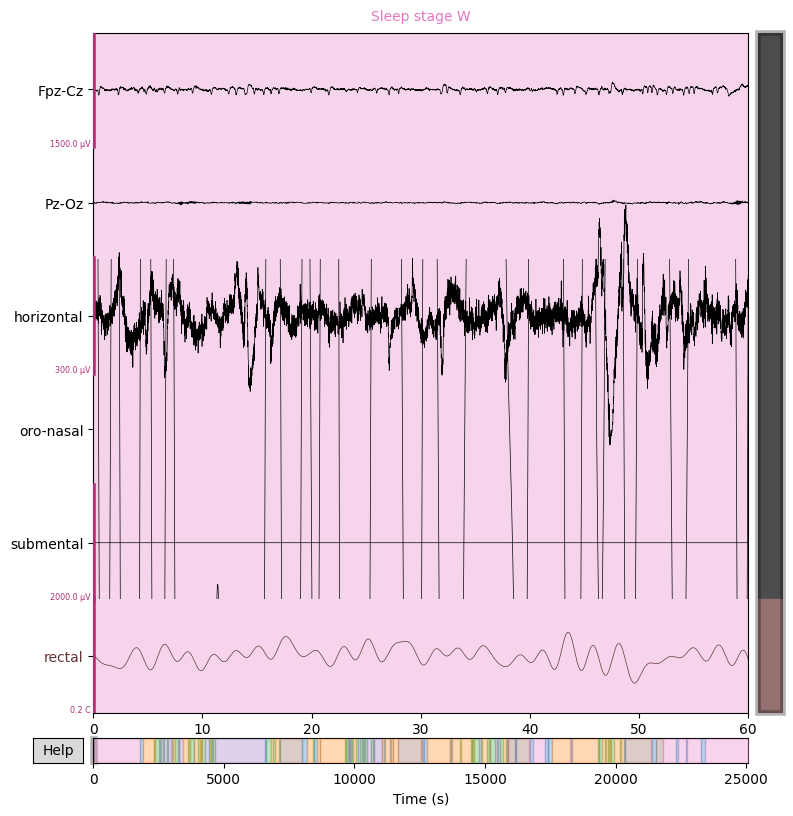

In [31]:
l_freq, h_freq = 0.3, 30 # filter between 0.3 and 30 Hz

for raw in raws:
    raw.filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')

raws[0].plot(duration=60, n_channels=30, scalings={'eeg': 75e-5})


c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


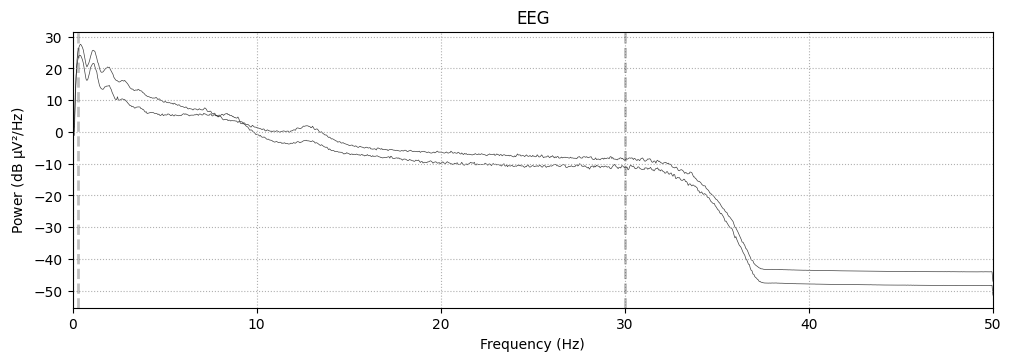

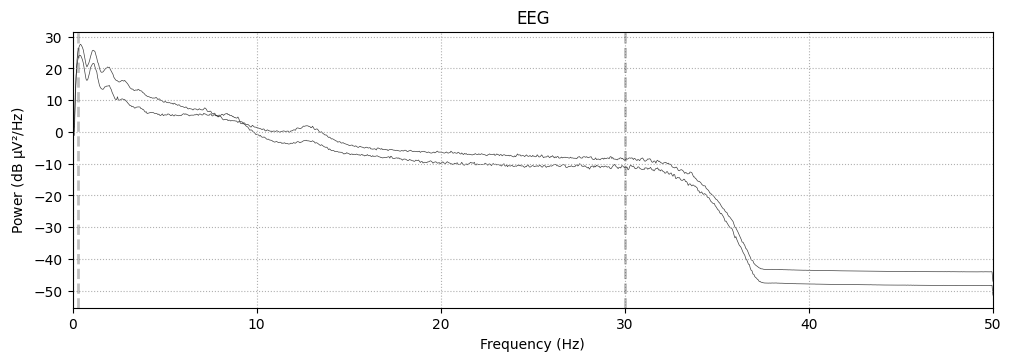

In [32]:
raws[0].plot_psd() # plot power spectral density

In [33]:
# extract epochs
def extract_epochs(raw_data):
    events, event_id = mne.events_from_annotations(raw_data, event_id={
        'Sleep stage W': 1, # wake
        'Sleep stage 1': 2, # N1
        'Sleep stage 2': 3, # N2
        'Sleep stage 3': 4, # put stage 3 and 4 together N3
        'Sleep stage 4': 4, # N3 as well
        'Sleep stage R': 5}) # REM
    tmax = 30.0 - 1.0 / raw_data.info['sfreq']  # epoch duration of 30 seconds
    epochs = mne.Epochs(raw_data, events, event_id, tmin=0., tmax=tmax, baseline=None, preload=True)
    return epochs

epochs = []
for raw in raws:
    epochs.append(extract_epochs(raw))


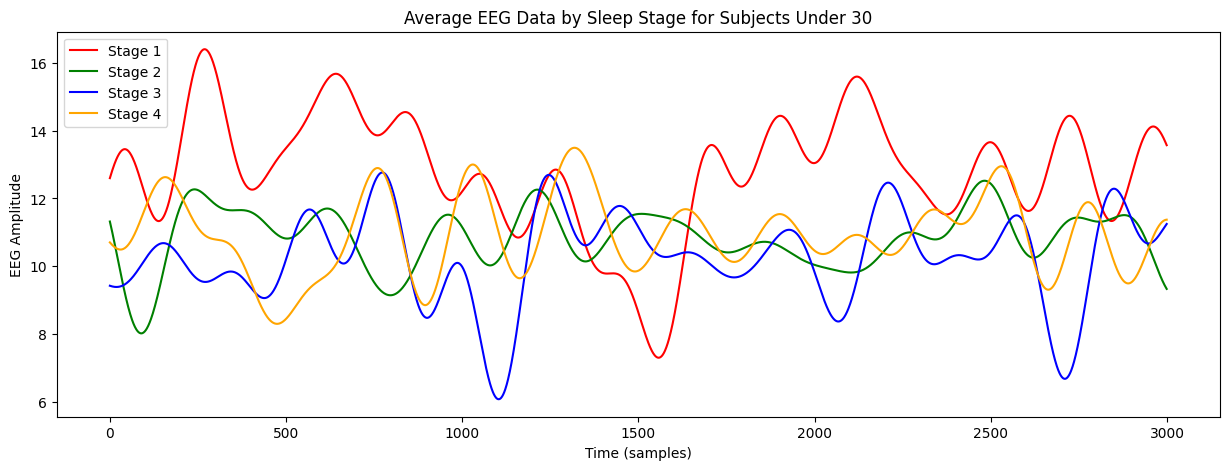

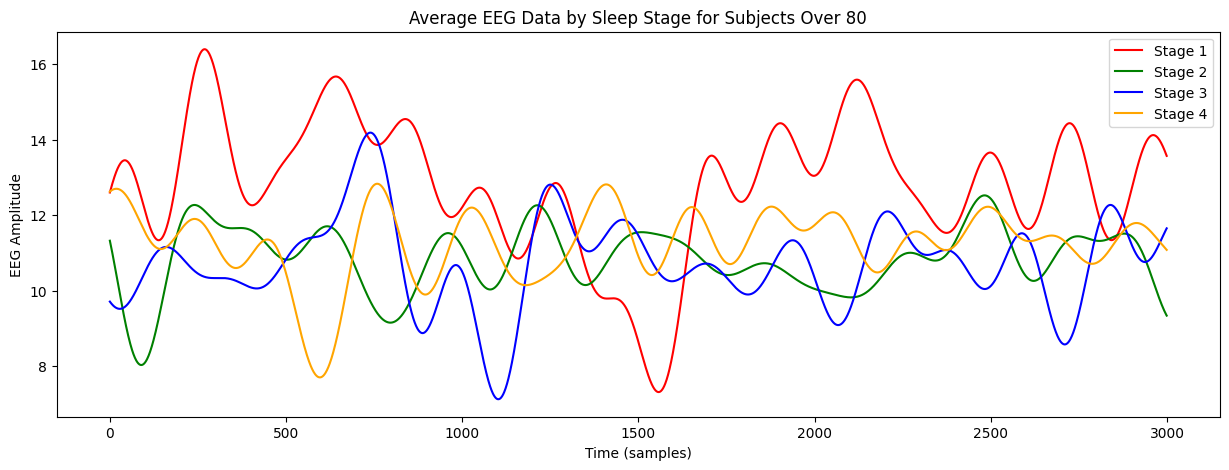

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def plot_average_by_stage(epochs_list, title):
    stages = range(1, 7)  # sleep stages 1 to 5 (W, N1, N2, N3, R)
    colors = ['red', 'green', 'blue', 'orange']  # Colors for stages

    plt.figure(figsize=(15, 5))
    for stage, color in zip(stages, colors):
        stage_data = np.concatenate([epochs[i].get_data()[epochs[i].events[:, 2] == stage] for i in range(len(epochs_list))], axis=0)
        average_stage_data = np.mean(stage_data, axis=0)
        plt.plot(average_stage_data.mean(axis=0), label=f'Stage {stage}', color=color)

    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('EEG Amplitude')
    plt.legend()
    plt.show()

# filter subjects based on age and extract epochs
epochs_under_30 = []
epochs_over_80 = []

for raw, age in zip(raws, ages):
    epochs = extract_epochs(raw)
    if age < 30:
        epochs_under_30.append(epochs)
    elif age > 80:
        epochs_over_80.append(epochs)

plot_average_by_stage(epochs_under_30, 'Average EEG Data by Sleep Stage for Subjects Under 30')
plot_average_by_stage(epochs_over_80, 'Average EEG Data by Sleep Stage for Subjects Over 80')


c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


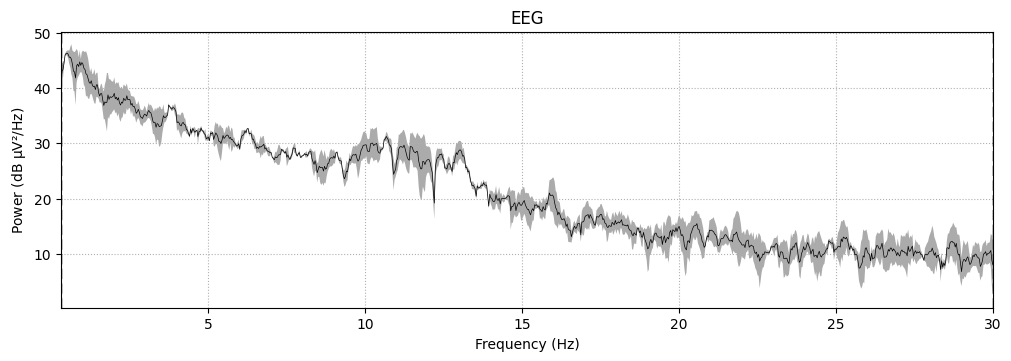

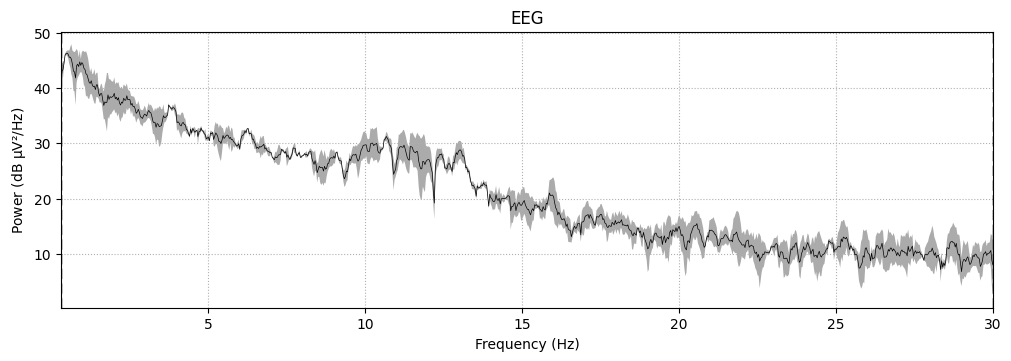

In [35]:
epochs[7].plot_psd(fmin=0.3, fmax=30, average=True, spatial_colors=True) # plot power spectral density

### Part 2: Feature Selection

#### Feature Extraction Methods 

For feature extraction, we will use the following methods:
- band power: delta, theta, alpha, beta, gamma
- pca of eeg data
- dwt of epochs 


In [36]:
import mne

def extract_epochs_with_grouping(raw_data, age):
    # print("Processing age:", age)
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,  # combining stages 3 and 4
        'Sleep stage 4': 4,
        'Sleep stage R': 5
    }
    tmax = 30.0 - 1.0 / raw_data.info['sfreq']
    # print("Calculated tmax:", tmax)
    events, event_mapping = mne.events_from_annotations(raw_data, event_id=event_id)
    # print("Found events:", event_mapping)

    if not events.size:
        print("No relevant events found for age:", age)
        return None, age

    epochs = mne.Epochs(raw_data, events, event_id, tmin=0., tmax=tmax, baseline=None,
                        preload=True, on_missing='ignore')
    return epochs, age


grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
epochs_under_30 = [ep for ep, age in grouped_epochs if age < 30]
epochs_over_80 = [ep for ep, age in grouped_epochs if age > 80]



In [37]:
print("nr subjects under 30:", len(epochs_under_30))
print("nr subjects over 80:", len(epochs_over_80))


nr subjects under 30: 11
nr subjects over 80: 16


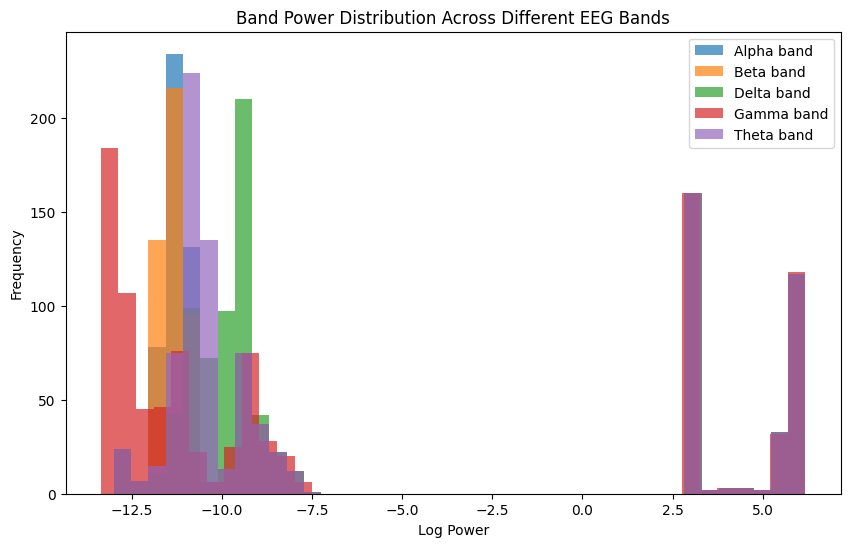

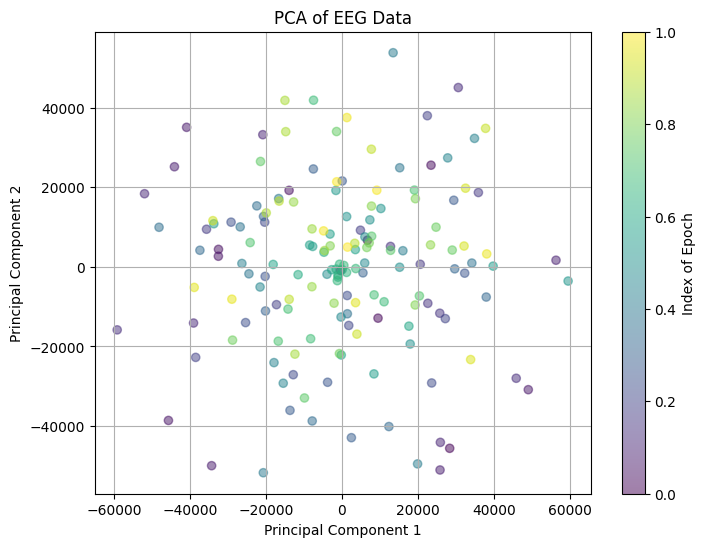

Explained variance ratio: [0.20990685 0.17039801]


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet
from sklearn.decomposition import PCA

# Band power calculation across multiple frequency bands
def calculate_band_power(epochs):
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40)  # Note: Gamma band typically goes up to 100 Hz, but EEG devices often have upper limits below this
    }
    features = {}
    plt.figure(figsize=(10, 6))
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
        plt.hist(band_power.ravel(), bins=40, alpha=0.7, label=f'{band} band')

    plt.title('Band Power Distribution Across Different EEG Bands')
    plt.xlabel('Log Power')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    return features

# Enhanced PCA visualization
def perform_pca(epochs):
    data = epochs.get_data().reshape(len(epochs), -1)
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=np.linspace(0, 1, len(pca_data)), cmap='viridis', alpha=0.5)
    plt.colorbar(label='Index of Epoch')
    plt.title('PCA of EEG Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()
    print("Explained variance ratio:", pca.explained_variance_ratio_)


epochs_example = epochs_under_30[0]  # Assuming epochs_under_30 is already defined
calculate_band_power(epochs_example)
perform_pca(epochs_example)


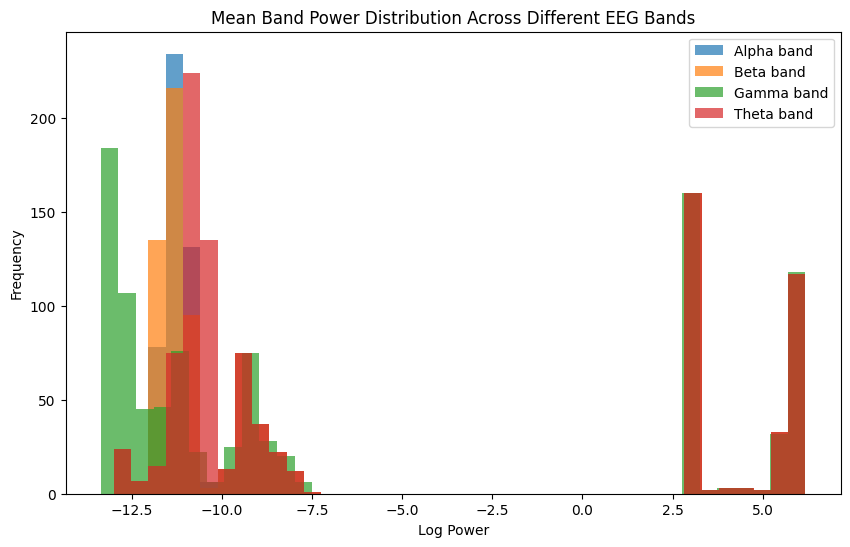

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mne.time_frequency import tfr_morlet
from sklearn.decomposition import PCA

# Band power calculation across multiple frequency bands
def calculate_band_power(epochs):
    bands = {
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40)  # Note: Gamma band typically goes up to 100 Hz, but EEG devices often have upper limits below this
    }
    features = {}
    plt.figure(figsize=(10, 6))
    
    mean_band_powers = {}  # Dictionary to store mean band power
    
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
        plt.hist(band_power.ravel(), bins=40, alpha=0.7, label=f'{band} band')
        
        # Calculate and store mean band power
        mean_band_powers[band] = np.mean(band_power)
    
    plt.title('Mean Band Power Distribution Across Different EEG Bands')
    plt.xlabel('Log Power')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return mean_band_powers

mean_band_powers = calculate_band_power(epochs_example)



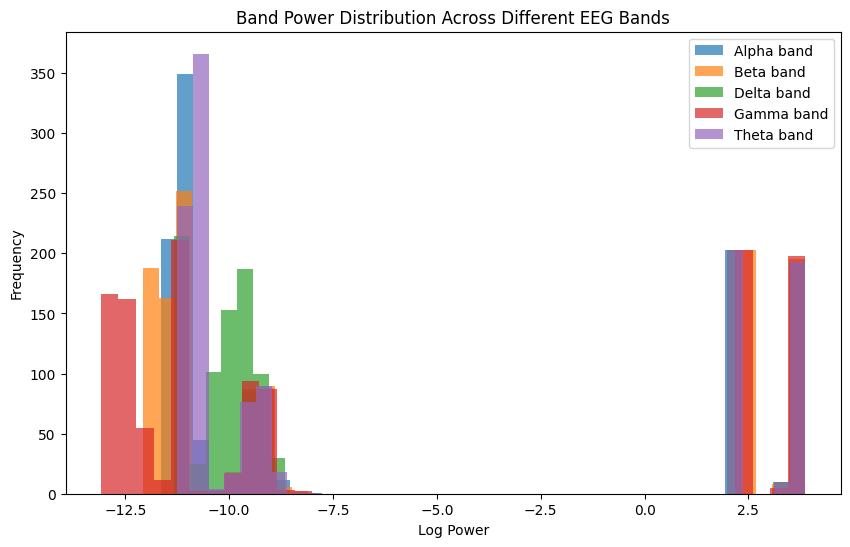

NameError: name 'bands' is not defined

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming mean_band_powers contains the mean power for each band
mean_band_powers = calculate_band_power(epochs_example)

# Calculate total power
total_power = np.sum(list(mean_band_powers.values()))

# Calculate relative power for each band
relative_power = {band: power / total_power for band, power in mean_band_powers.items()}

# Calculate variance, skewness, and kurtosis for each band power distribution
band_variances = {}
band_skewness = {}
band_kurtosis = {}

for band in mean_band_powers.keys():
    band_data = epochs.copy().filter(l_freq=bands[band][0], h_freq=bands[band][1], fir_design='firwin').get_data()
    band_power = np.log10(np.mean(band_data**2, axis=2)).ravel()
    band_variances[band] = np.var(band_power)
    band_skewness[band] = skew(band_power)
    band_kurtosis[band] = kurtosis(band_power)

# Combine all features into a single DataFrame
features_df = pd.DataFrame({
    'Mean_Power': mean_band_powers,
    'Relative_Power': relative_power,
    'Variance': band_variances,
    'Skewness': band_skewness,
    'Kurtosis': band_kurtosis
})

# Add ratio features
features_df['Alpha_Beta_Ratio'] = features_df.loc['Alpha', 'Mean_Power'] / features_df.loc['Beta', 'Mean_Power']
features_df['Theta_Alpha_Ratio'] = features_df.loc['Theta', 'Mean_Power'] / features_df.loc['Alpha', 'Mean_Power']

# Perform PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features_df)
features_df['PCA1'] = pca_features[:, 0]
features_df['PCA2'] = pca_features[:, 1]

# Display the features DataFrame
import ace_tools as tools; tools.display_dataframe_to_user(name="EEG Band Power Features", dataframe=features_df)

print("Selected Features DataFrame:")
print(features_df)


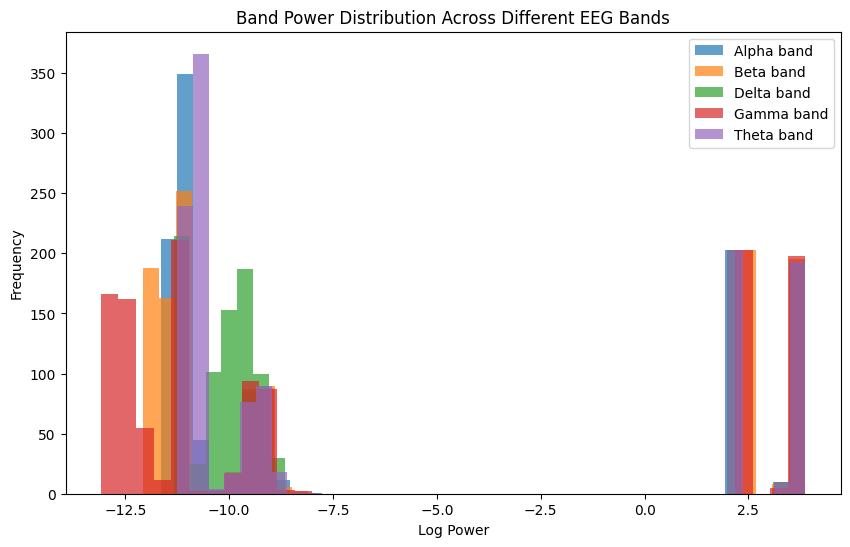

{'Alpha': array([-11.18488576, -11.22360058,  -9.31981617,   3.64190751,
        -11.03926969,   2.30737818]),
 'Beta': array([-11.49889971, -11.71040237,  -9.31981617,   3.64190751,
        -11.03926969,   2.30737818]),
 'Delta': array([ -9.82147669, -10.25978947,  -9.31981617,   3.64190751,
        -11.03926969,   2.30737818]),
 'Gamma': array([-12.31267406, -12.71503171,  -9.31981617,   3.64190751,
        -11.03926969,   2.30737818]),
 'Theta': array([-10.6868069 , -10.71765014,  -9.31981617,   3.64190751,
        -11.03926969,   2.30737818])}

In [24]:
epochs_example = epochs_over_80[0]  # Assuming epochs_under_30 is already defined
calculate_band_power(epochs_example)


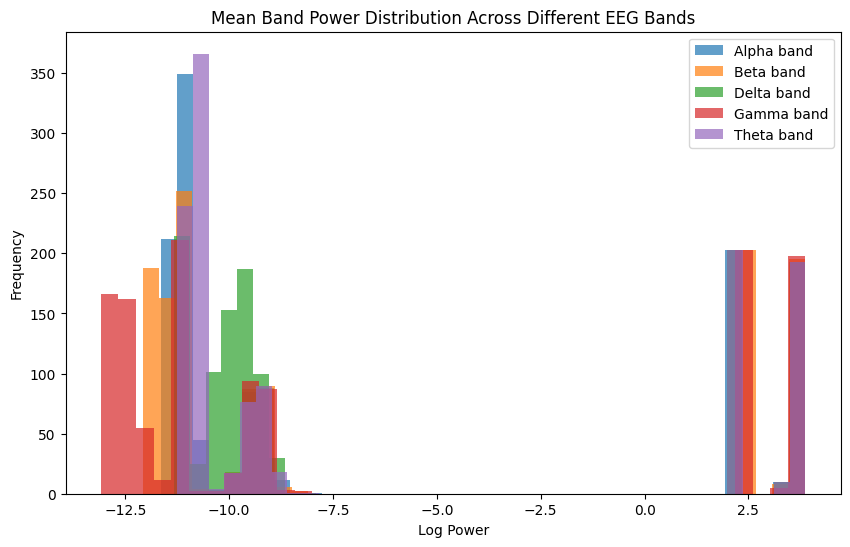

ModuleNotFoundError: No module named 'ace_tools'

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA

# Calculate band power and return detailed features
def calculate_detailed_band_power(epochs):
    bands = {
        'Delta': (1, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40)
    }
    features = {}
    mean_band_powers = {}
    variances = {}
    skewnesses = {}
    kurtoses = {}
    
    plt.figure(figsize=(10, 6))
    
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
        
        # Calculate mean, variance, skewness, and kurtosis
        mean_band_powers[band] = np.mean(band_power)
        variances[band] = np.var(band_power)
        skewnesses[band] = skew(band_power.ravel())
        kurtoses[band] = kurtosis(band_power.ravel())
        
        plt.hist(band_power.ravel(), bins=40, alpha=0.7, label=f'{band} band')
    
    plt.title('Mean Band Power Distribution Across Different EEG Bands')
    plt.xlabel('Log Power')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    # Calculate total power and relative power
    total_power = sum(mean_band_powers.values())
    relative_powers = {band: power / total_power for band, power in mean_band_powers.items()}
    
    # Create DataFrame with all features
    features_df = pd.DataFrame({
        'Mean_Power': mean_band_powers,
        'Relative_Power': relative_powers,
        'Variance': variances,
        'Skewness': skewnesses,
        'Kurtosis': kurtoses
    })
    
    # Add ratio features
    features_df['Alpha_Beta_Ratio'] = features_df.loc['Alpha', 'Mean_Power'] / features_df.loc['Beta', 'Mean_Power']
    features_df['Theta_Alpha_Ratio'] = features_df.loc['Theta', 'Mean_Power'] / features_df.loc['Alpha', 'Mean_Power']
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features_df)
    features_df['PCA1'] = pca_features[:, 0]
    features_df['PCA2'] = pca_features[:, 1]
    
    return features_df

# Example usage
# Replace 'epochs_example' with the appropriate epochs object in your context
features_df = calculate_detailed_band_power(epochs_example)
import ace_tools as tools; tools.display_dataframe_to_user(name="EEG Band Power Features", dataframe=features_df)

print("Selected Features DataFrame:")
print(features_df)


C:\Users\rebec\AppData\Local\Temp\ipykernel_14360\199645660.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


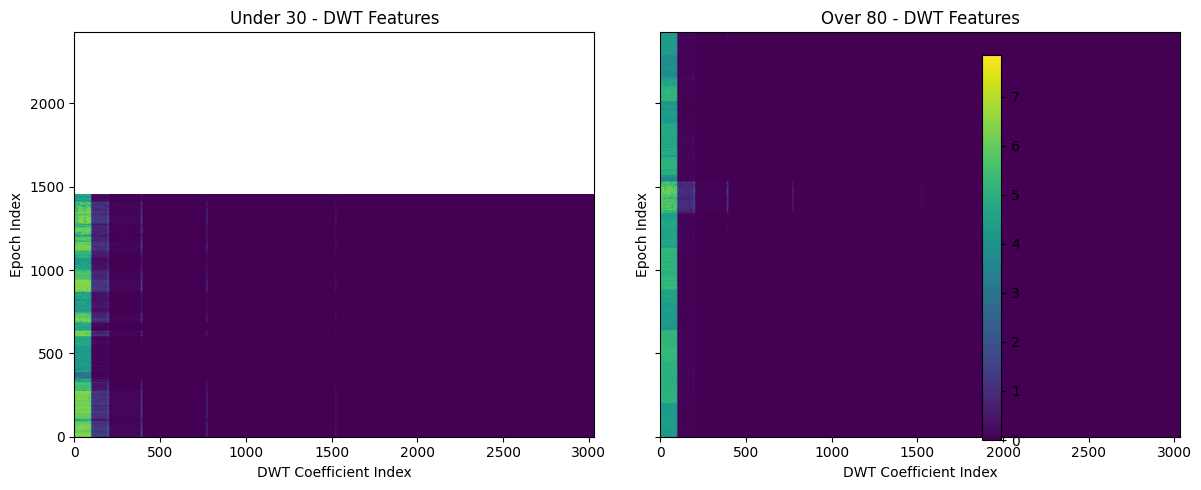

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import pywt
from mne.time_frequency import tfr_morlet


def get_dwt_features(epochs, wavelet='db4', level=5):
    data = epochs.get_data()  #  (n_epochs, n_channels, n_times)
    coefficients = []
    for epoch_data in data:
        channel_coeffs = []
        for channel_data in epoch_data:
            coeffs = pywt.wavedec(channel_data, wavelet, level=level)
            concatenated_coeffs = np.hstack([c.ravel() for c in coeffs])
            channel_coeffs.append(concatenated_coeffs)
        coefficients.append(np.mean(channel_coeffs, axis=0))
    return np.array(coefficients)

def plot_dwt_features(group1, group2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    for ax, group, title in zip(axes, [group1, group2], [title1, title2]):
        concatenated_data = mne.concatenate_epochs(group)
        features = get_dwt_features(concatenated_data)
        ax.imshow(np.log1p(np.abs(features)), aspect='auto', cmap='viridis', origin='lower')
        ax.set_title(title)
        ax.set_xlabel('DWT Coefficient Index')
        ax.set_ylabel('Epoch Index')
    plt.colorbar(axes[1].images[0], ax=axes, orientation='vertical', fraction=.1)
    plt.tight_layout()
    plt.show()


def analyze_eeg_data(raws, ages):
    grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
    grouped_epochs = [ge for ge in grouped_epochs if ge[0] is not None]

    epochs_under_30 = [ep for ep, age in grouped_epochs if age < 30]
    epochs_over_80 = [ep for ep, age in grouped_epochs if age > 80]

    if epochs_under_30 and epochs_over_80:
        plot_dwt_features(epochs_under_30, epochs_over_80, 'Under 30 - DWT Features', 'Over 80 - DWT Features')
    else:
        print("not enough data in one or both age groups for analysis.")

analyze_eeg_data(raws, ages)



# Part 3 
### Feature selection 

### only focusing on Theta and Gamma band power

We try out models using Theta and Gamma band power as features. We will use the following models:
- Logistic Regression (using 2 bands featues vs. 4 bands featues )
- SVM (3 classes including others class) using 2 bands featues vs. 4 bands featues
- adding also other features other band passes 

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate, permutation_test_score

In [46]:
# choose features / features selection
def calculate_band_power1(epochs):
    bands = {
        'Theta': (4, 8),
        'Gamma': (30, 40)
    }
    features = {}
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
    return features

def calculate_band_power2(epochs): # more bands / features
    bands = {
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40),
    }
    features = {}
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
    return features

 age: 33,  label: 2
 age: 33,  label: 2
 age: 26,  label: 0
 age: 26,  label: 0
 age: 34,  label: 2
 age: 28,  label: 0
 age: 31,  label: 2
 age: 30,  label: 0
 age: 25,  label: 0
 age: 25,  label: 0
 age: 26,  label: 0
 age: 26,  label: 0
 age: 26,  label: 0
 age: 27,  label: 0
 age: 31,  label: 2
 age: 32,  label: 2
 age: 31,  label: 2
 age: 28,  label: 0
 age: 28,  label: 0
 age: 51,  label: 2
 age: 51,  label: 2
 age: 56,  label: 2
 age: 49,  label: 2
 age: 54,  label: 2
 age: 56,  label: 2
 age: 51,  label: 2
 age: 54,  label: 2
 age: 56,  label: 2
 age: 51,  label: 2
 age: 50,  label: 2
 age: 54,  label: 2
 age: 57,  label: 2
 age: 60,  label: 2
 age: 54,  label: 2
 age: 57,  label: 2
 age: 52,  label: 2
 age: 51,  label: 2
 age: 67,  label: 2
 age: 66,  label: 2
 age: 69,  label: 2
 age: 73,  label: 2
 age: 74,  label: 2
 age: 66,  label: 2
 age: 66,  label: 2
 age: 73,  label: 2
 age: 66,  label: 2
 age: 67,  label: 2
 age: 71,  label: 2
 age: 70,  label: 2
 age: 66,  label: 2


c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


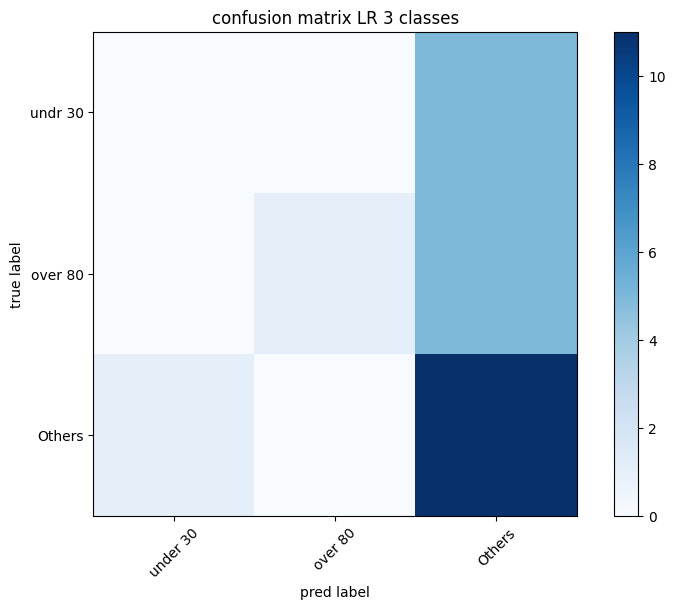

In [48]:
# logistic regression model for multi-class classification 3 classes
def multi_class_classification(features_list, labels):
    all_features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.3, random_state=42)

    print("training  testing dataset size:")
    print("nr of training samples:", len(y_train))
    print("nr of testing samples:", len(y_test))
    print("class dist in training set:", np.bincount(y_train))
    print("class dist in testing set:", np.bincount(y_test))


    model = LogisticRegression(max_iter=1000,multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('confusion matrix LR 3 classes')
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ['under 30', 'over 80', 'Others'], rotation=45)
    plt.yticks(tick_marks, ['undr 30', 'over 80', 'Others'])
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('pred label')
    plt.show()

def main(grouped_epochs):
    features_list = []
    labels = []

    for epochs, age in grouped_epochs:
        if epochs is not None:
            features = calculate_band_power2(epochs)
            features_list.append(features)
            if age <= 30:
                label = 0
            elif age >= 80:
                label = 1
            else:
                label = 2 # Other ages
            labels.append(label)
            print(f" age: {age},  label: {label}")

    if features_list:
        print(f"total samples: {len(labels)}, labels: {labels}")
        multi_class_classification(features_list, labels)
    else:
        print("-")

grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
main(grouped_epochs)


Processed age: 33, Assigned label: 2
Processed age: 33, Assigned label: 2
Processed age: 26, Assigned label: 0
Processed age: 26, Assigned label: 0
Processed age: 34, Assigned label: 2
Processed age: 28, Assigned label: 0
Processed age: 31, Assigned label: 2
Processed age: 30, Assigned label: 0
Processed age: 25, Assigned label: 0
Processed age: 25, Assigned label: 0
Processed age: 26, Assigned label: 0
Processed age: 26, Assigned label: 0
Processed age: 26, Assigned label: 0
Processed age: 27, Assigned label: 0
Processed age: 31, Assigned label: 2
Processed age: 32, Assigned label: 2
Processed age: 31, Assigned label: 2
Processed age: 28, Assigned label: 0
Processed age: 28, Assigned label: 0
Processed age: 51, Assigned label: 2
Processed age: 51, Assigned label: 2
Processed age: 56, Assigned label: 2
Processed age: 49, Assigned label: 2
Processed age: 54, Assigned label: 2
Processed age: 56, Assigned label: 2
Processed age: 51, Assigned label: 2
Processed age: 54, Assigned label: 2
P

c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\rebec\miniconda3\envs\GPU-new\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


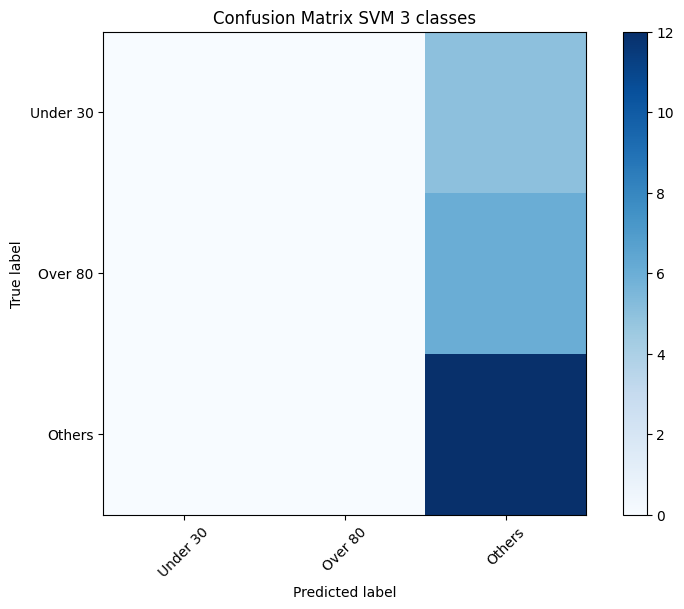

In [50]:
# use support vector machine with rbf kernel in 3 classes
def multi_class_classification(features_list, labels):
    all_features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.3, random_state=42)

    print("Training and testing dataset size:")
    print("Number of training samples:", len(y_train))
    print("Number of testing samples:", len(y_test))
    print("Class distribution in training set:", np.bincount(y_train))
    print("Class distribution in testing set:", np.bincount(y_test))

    model = SVC(kernel='rbf', C=1.0, decision_function_shape='ovo')  # svm with rbf kernel
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix SVM 3 classes')
    plt.colorbar()
    tick_marks = np.arange(3)
    plt.xticks(tick_marks, ['Under 30', 'Over 80', 'Others'], rotation=45)
    plt.yticks(tick_marks, ['Under 30', 'Over 80', 'Others'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def main(grouped_epochs):
    features_list = []
    labels = []

    for epochs, age in grouped_epochs:
        if epochs is not None:
            features = calculate_band_power2(epochs) # only 2 bands test
            features_list.append(features)
            if age <= 30:
                label = 0
            elif age >= 80:
                label = 1
            else:
                label = 2  # other ages
            labels.append(label)
            print(f"Processed age: {age}, Assigned label: {label}")

    if features_list:
        print(f"Total samples: {len(labels)}, Labels: {labels}")
        multi_class_classification(features_list, labels)
    else:
        print("Not enough data for analysis.")

# Usage example
grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
main(grouped_epochs)


Processed age: 26,  label: 0
Processed age: 26,  label: 0
Processed age: 28,  label: 0
Processed age: 30,  label: 0
Processed age: 25,  label: 0
Processed age: 25,  label: 0
Processed age: 26,  label: 0
Processed age: 26,  label: 0
Processed age: 26,  label: 0
Processed age: 27,  label: 0
Processed age: 28,  label: 0
Processed age: 28,  label: 0
Processed age: 89,  label: 1
Processed age: 101,  label: 1
Processed age: 95,  label: 1
Processed age: 91,  label: 1
Processed age: 85,  label: 1
Processed age: 88,  label: 1
Processed age: 88,  label: 1
Processed age: 87,  label: 1
Processed age: 89,  label: 1
Processed age: 88,  label: 1
Processed age: 88,  label: 1
Processed age: 97,  label: 1
Processed age: 92,  label: 1
Processed age: 96,  label: 1
Processed age: 90,  label: 1
Processed age: 85,  label: 1
tot samples: 28, labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Training and testing dataset size:
Number of training samples: 19
Number of t

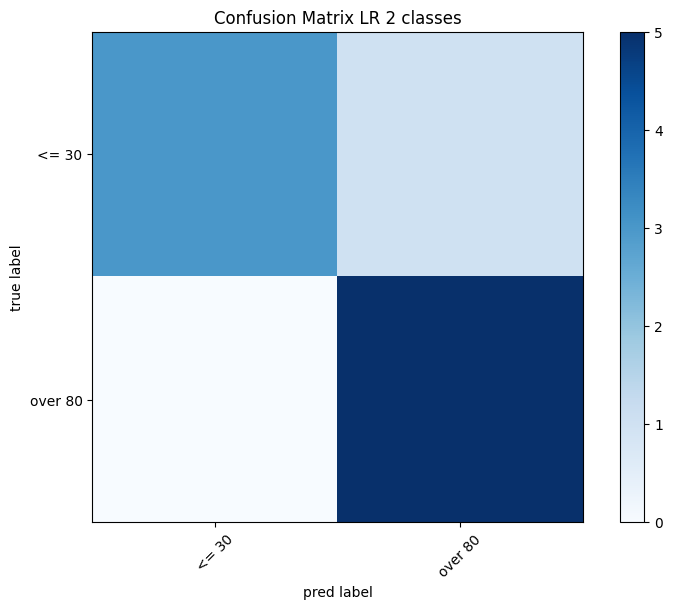

accuracy: 0.8933333333333333 +/- 0.08793937305515276
precision: 0.9 +/- 0.1224744871391589
recall: 0.95 +/- 0.09999999999999999
f1: 0.9142857142857143 +/- 0.06998542122237654


In [51]:

# binary classification two classes using 4 bands/features
def binary_classification(features_list, labels):
    all_features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.3, random_state=42)

    print("Training and testing dataset size:")
    print("Number of training samples:", len(y_train))
    print("Number of testing samples:", len(y_test))
    print("Class distribution in training set:", np.bincount(y_train))
    print("Class distribution in testing set:", np.bincount(y_test))

    model = LogisticRegression(max_iter=1000,multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix LR 2 classes')
    plt.colorbar()
    plt.xticks(np.arange(2), ['<= 30', 'over 80'], rotation=45)
    plt.yticks(np.arange(2), ['<= 30', 'over 80'])
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('pred label')
    plt.show()
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = {}
    for metric in scoring:
        scores[metric] = cross_val_score(model, all_features, labels, cv=5, scoring=metric)

    # mean performance with standard deviation
    for metric in scores.keys():
        print(f"{metric}: {scores[metric].mean()} +/- {scores[metric].std()}")

def main(grouped_epochs):
    features_list = []
    labels = []

    for epochs, age in grouped_epochs:
        if epochs is not None:
            if age <= 30 or age >= 80:
                features = calculate_band_power2(epochs) # test more bands /4 features bands
                features_list.append(features)
                if age <= 30:
                    label = 0
                elif age >= 80:
                    label = 1
                labels.append(label)
                print(f"Processed age: {age},  label: {label}")

    if features_list:
        print(f"tot samples: {len(labels)}, labels: {labels}")
        binary_classification(features_list, labels)
    else:
        print("-")


grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
main(grouped_epochs)


Processing age: 33
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 33
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 26
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 26
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 34
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 28
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Time-Series-Exercises-lHO8A0W6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Time-Series-Exercises-lHO8A0W6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Time-Series-Exercises-lHO8A0W6/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set 

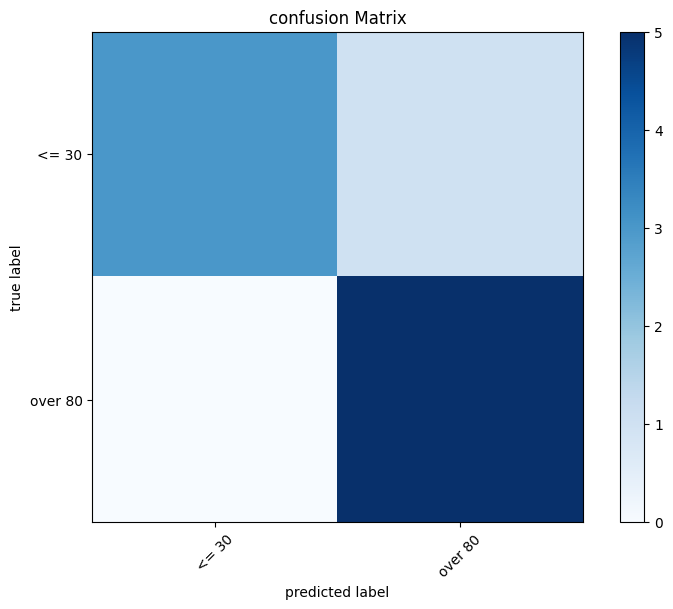

accuracy: 0.8933333333333333 +/- 0.08793937305515276
precision: 0.9 +/- 0.1224744871391589
recall: 0.95 +/- 0.09999999999999999
f1: 0.9142857142857143 +/- 0.06998542122237654


In [ ]:

# logistic regression binary classification with 4 bands/features
def binary_classification(features_list, labels):
    all_features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    X_train, X_test, y_train, y_test = train_test_split(all_features, labels, test_size=0.3, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  # Further split the training set into training and validation sets

    print("Training, validation, and testing dataset sizes:")
    print("Number of training samples:", len(y_train))
    print("Number of validation samples:", len(y_val))
    print("Number of testing samples:", len(y_test))
    print("Class distribution in training set:", np.bincount(y_train))
    print("Class distribution in validation set:", np.bincount(y_val))
    print("Class distribution in testing set:", np.bincount(y_test))

    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(X_train, y_train)

    # validation set
    val_predictions = model.predict(X_val)
    print("validation set perf:")
    print(classification_report(y_val, val_predictions))

    test_predictions = model.predict(X_test)
    print("testing set perf:")
    print(classification_report(y_test, test_predictions))

    cm = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(2), ['<= 30', 'over 80'], rotation=45)
    plt.yticks(np.arange(2), ['<= 30', 'over 80'])
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('predicted label')
    plt.show()

    #  cross-validation
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    scores = {}
    for metric in scoring:
        scores[metric] = cross_val_score(model, all_features, labels, cv=5, scoring=metric)

    #mean performance with standard deviation
    for metric in scores.keys():
        print(f"{metric}: {scores[metric].mean()} +/- {scores[metric].std()}")

def main(grouped_epochs):
    features_list = []
    labels = []

    for epochs, age in grouped_epochs:
        if epochs is not None:
            if age <= 30 or age >= 80:
                features = calculate_band_power2(epochs)
                features_list.append(features)
                if age <= 30:
                    label = 0
                elif age >= 80:
                    label = 1
                labels.append(label)
                print(f"Processed age: {age},  label: {label}")

    if features_list:
        print(f"total samples: {len(labels)}, Labels: {labels}")
        binary_classification(features_list, labels)
    else:
        print("-")

grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
main(grouped_epochs)


# Part 4 


In [ ]:
for epoch, age in grouped_epochs:
    if epochs is not None:
        if age <= 30 or age >= 80:
            print(epoch.get_data().shape[2])


(160, 6, 3000)
(118, 6, 3000)
(129, 6, 3000)
(115, 6, 3000)
(141, 6, 3000)
(137, 6, 3000)
(61, 6, 3000)
(124, 6, 3000)
(127, 6, 3000)
(121, 6, 3000)
(160, 6, 3000)
(177, 6, 3000)
(203, 6, 3000)
(249, 6, 3000)
(189, 6, 3000)
(157, 6, 3000)
(87, 6, 3000)
(250, 6, 3000)
(206, 6, 3000)
(228, 6, 3000)
(108, 6, 3000)
(127, 6, 3000)
(76, 6, 3000)
(132, 6, 3000)
(89, 6, 3000)
(57, 6, 3000)
(134, 6, 3000)
(135, 6, 3000)


Processing age: 33
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 33
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 26
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 26
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 34
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage R': 5, 'Sleep stage W': 1}
Processing age: 28
Calculated tmax: 29.99
Found events: {'Sleep stage 1': 2, 'Sleep stage 2': 3, 'Sleep stage 3': 4, 'Sleep stage 4': 4

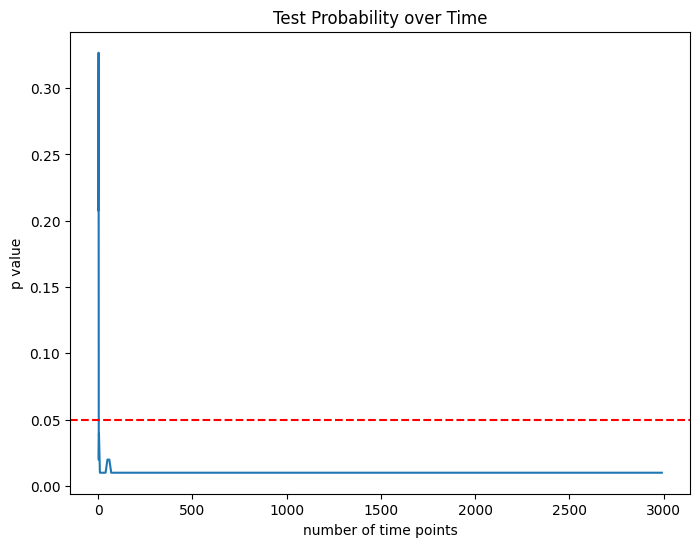

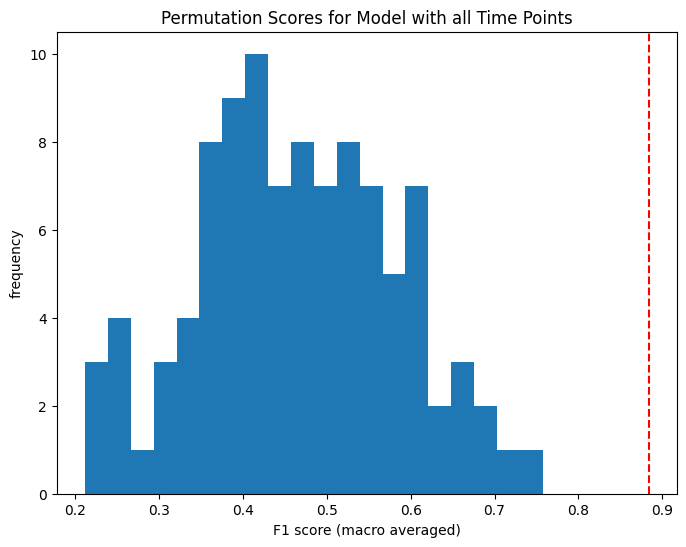

In [ ]:
def calculate_band_power2_with_n_time_points(epochs, n_time_points): # more bands / features
    sfreq = epochs.info['sfreq']
    time_step = 1 / sfreq

    bands = {
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 40),
    }
    features = {}
    for band, (l_freq, h_freq) in sorted(bands.items()):
        epochs_band = epochs.copy().crop(tmin=0, tmax=n_time_points * time_step).filter(l_freq=l_freq, h_freq=h_freq, fir_design='firwin')
        data = epochs_band.get_data()
        band_power = np.log10(np.mean(data**2, axis=2))
        features[band] = band_power.mean(axis=0)
    return features

# logistic regression binary classification with 4 bands/features
def run_permutation_test(grouped_epochs, cls):
    labels = []
    total_num_time_points = 0
    for epochs, age in grouped_epochs:
        if epochs is not None:
            if age <= 30 or age >= 80:
                if age <= 30:
                    label = 0
                elif age >= 80:
                    label = 1
                labels.append(label)

                if epoch.get_data().shape[2] > total_num_time_points:
                    total_num_time_points = epoch.get_data().shape[2]

    num_feature_values = [1, 2, 3, 4, 5, *range(10, total_num_time_points, 10)]

    scores = []
    all_permutation_scores = []
    p_values = []
    for num_features in num_feature_values:
        print(f'training with {num_features} time points')

        features_list = []
        for epochs, age in grouped_epochs:
            if epochs is not None:
                if age <= 30 or age >= 80:
                    features_list.append(calculate_band_power2_with_n_time_points(epochs, num_features))

        features = np.vstack([np.hstack([features[band][0:num_features] for band in sorted(features)]) for features in features_list])

        score, permutation_scores, p_value = permutation_test_score(cls(), features, labels, cv=5, scoring='f1_macro')
        scores.append(score)
        all_permutation_scores.append(permutation_scores)
        p_values.append(p_value)

    plt.figure(figsize=(8, 6))
    plt.plot(num_feature_values, p_values)
    plt.axhline(0.05, ls="--", color="r")
    plt.title('Test Probability over Time')
    plt.ylabel('p-value')
    plt.xlabel('number of time points')
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.hist(all_permutation_scores[-1], bins=20)
    plt.axvline(scores[-1], ls="--", color="r")
    score_label = f"Score on original\ndata: {scores[-1]:.2f}\n(p-value: {p_values[-1]:.3f})"
    plt.text(0.7, 10, score_label, fontsize=12)
    plt.title('Permutation Scores for Model with all Time Points')
    plt.ylabel('frequency')
    plt.xlabel('F1 score (macro averaged)')
    plt.show()


grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
cls = lambda: LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
run_permutation_test(grouped_epochs, cls)


training with 1 time points
training with 2 time points
training with 3 time points
training with 4 time points
training with 5 time points
training with 10 time points
training with 20 time points
training with 30 time points
training with 40 time points
training with 50 time points
training with 60 time points
training with 70 time points
training with 80 time points
training with 90 time points
training with 100 time points
training with 110 time points
training with 120 time points
training with 130 time points
training with 140 time points
training with 150 time points
training with 160 time points
training with 170 time points
training with 180 time points
training with 190 time points
training with 200 time points
training with 210 time points
training with 220 time points
training with 230 time points
training with 240 time points
training with 250 time points
training with 260 time points
training with 270 time points
training with 280 time points
training with 290 time points

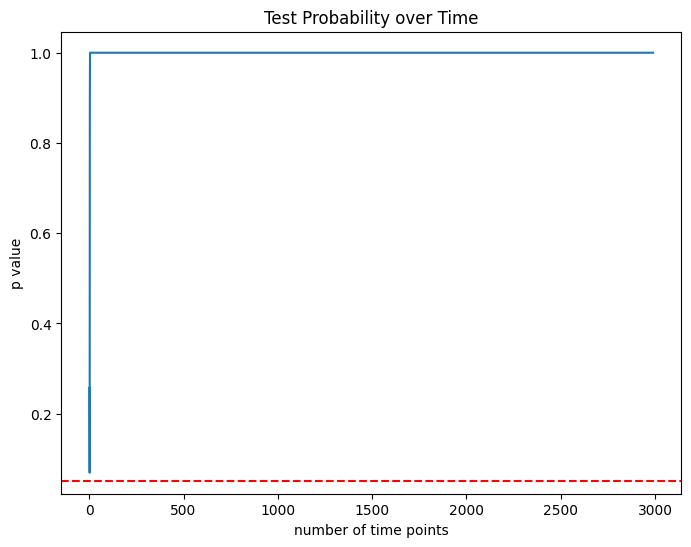

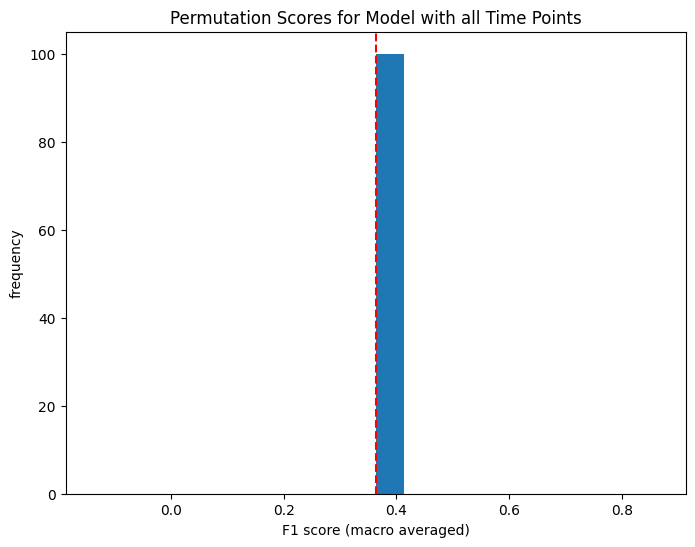

In [ ]:
cls = lambda: SVC(kernel='rbf', C=1.0, decision_function_shape='ovo')  # svm with rbf kernel
run_permutation_test(grouped_epochs, cls)

# Part 5


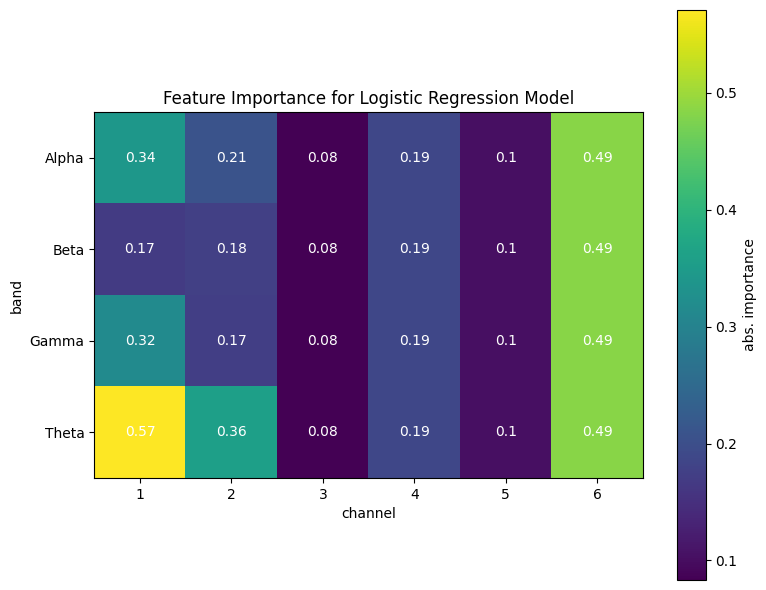

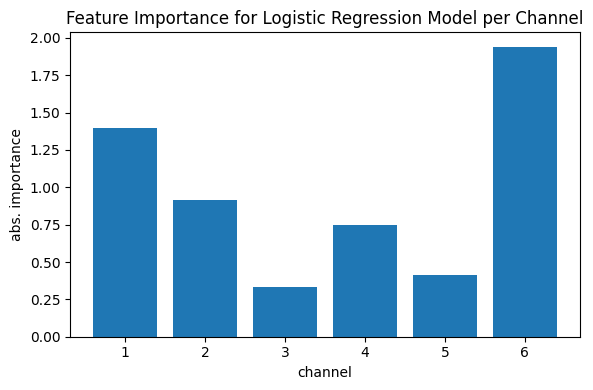

In [ ]:
# logistic regression binary classification with 4 bands/features
def show_feature_importance(grouped_epochs):
    features_list = []
    labels = []
    for epochs, age in grouped_epochs:
        if epochs is not None:
            if age <= 30 or age >= 80:
                features_list.append(calculate_band_power2(epochs))

                if age <= 30:
                    label = 0
                elif age >= 80:
                    label = 1
                labels.append(label)

    features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
    model.fit(features, labels)

    importances = np.abs(model.coef_.reshape(4, 6))

    fig, ax = plt.subplots(figsize=(8, 6))
    plt.imshow(importances)
    for i in range(importances.shape[0]):
        for j in range(importances.shape[1]):
            ax.text(j, i, round(importances[i, j], 2), ha="center", va="center", color="w")

    plt.title('Feature Importance for Logistic Regression Model')
    plt.ylabel('band')
    plt.xlabel('channel')
    ax.set_xticks(range(0, 6))
    ax.set_xticklabels(range(1, 7))
    ax.set_yticks(range(0, 4))
    ax.set_yticklabels(features_list[0].keys())
    plt.colorbar(label='abs. importance')
    plt.tight_layout()
    plt.show()

    channel_importances = importances.sum(axis=0)
    fig, ax = plt.subplots(figsize=(6, 4))
    plt.bar(range(1, 7), channel_importances)
    plt.title('Feature Importance for Logistic Regression Model per Channel')
    plt.ylabel('abs. importance')
    plt.xlabel('channel')
    plt.tight_layout()
    plt.show()


grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
show_feature_importance(grouped_epochs)


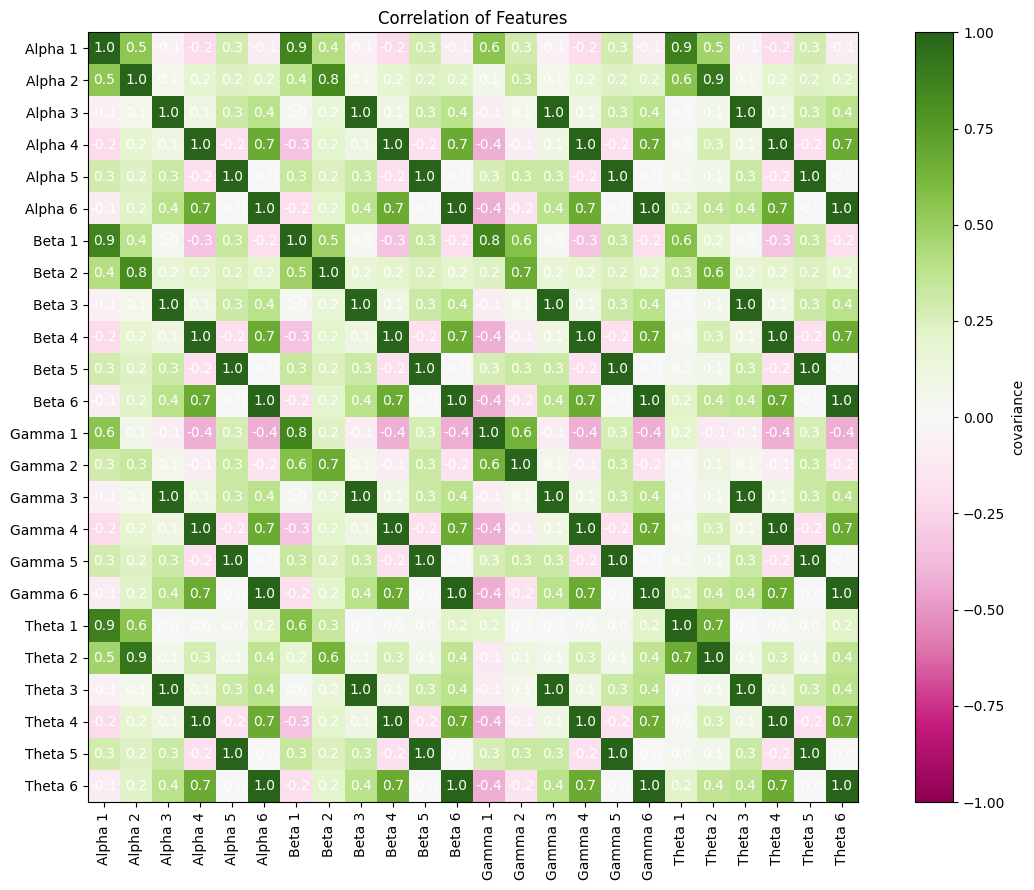

In [ ]:
def show_correlation(grouped_epochs):
    features_list = []
    labels = []
    for epochs, age in grouped_epochs:
        if epochs is not None:
            if age <= 30 or age >= 80:
                features_list.append(calculate_band_power2(epochs))

                if age <= 30:
                    label = 0
                elif age >= 80:
                    label = 1
                labels.append(label)

    features = np.vstack([np.hstack([features[band] for band in sorted(features)]) for features in features_list])
    corr = np.corrcoef(features.T)

    fig, ax = plt.subplots(figsize=(12, 9))
    plt.imshow(corr, cmap='PiYG', vmin=-1, vmax=1)
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, round(corr[i, j], 1), ha="center", va="center", color="w")

    plt.title('Correlation of Features')
    ax.set_xticks(range(corr.shape[0]))
    ax.set_xticklabels([f'{band} {i}' for band in features_list[0].keys() for i in range(1, 7)], rotation=90)
    ax.set_yticks(range(corr.shape[1]))
    ax.set_yticklabels([f'{band} {i}' for band in features_list[0].keys() for i in range(1, 7)])
    plt.colorbar(label='covariance')
    plt.tight_layout()
    plt.show()


grouped_epochs = [extract_epochs_with_grouping(raw, age) for raw, age in zip(raws, ages)]
show_correlation(grouped_epochs)


Corrlation of channels over bands: channels 3, 4, 5, 6 with 1.0, channel 1 und 2 only partially. thus the importances correlate as well. 